In [1]:
import sys
#%cd variational_inference_for_longitudinal_data/
sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
sys.path.append('lib/src/')
import torch
from torch import nn
import torch.nn.functional as F
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import logging




from diffusion.stable_diffusion.latent_diffusion import MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.unet import UNetModel
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler

from lib.src.pythae.models import VAE
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.models import LLDM_IAF, LVAE_IAF_Config
from lib.src.pythae.trainers import BaseTrainerConfig, BaseTrainer
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs
from lib.scripts.utils import My_MaskedDataset, make_batched_masks
from lib.src.pythae.trainers.training_callbacks import WandbCallback

from geometric_perspective_on_vaes.sampling import hmc_sampling


def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )


def plot_sequence(X):

    if len(X.shape) == 4:
        X = X.unsqueeze(0)

    X = X.cpu().detach().numpy()
    num_seq = X.shape[0]
    num_obs = X.shape[1]

    logger = logging.getLogger()
    old_level = logger.level
    logger.setLevel(100)
    plt.figure(figsize=(10, 10))
    for i in range(num_seq):
        for j in range(num_obs):
            plt.subplot(num_seq, num_obs, i*num_obs+j+1)
            plt.imshow(X[i, j].transpose(1, 2, 0))
            plt.axis('off')

    plt.show()
    logger.setLevel(old_level)


%reload_ext autoreload
%autoreload 2

!nvidia-smi

Fri Jul 26 11:54:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.100                Driver Version: 550.100        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:01:00.0 Off |                  Off |
| 30%   48C    P8             11W /   70W |     119MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
PATH_DATA = 'lib/my_data/sprites/Sprites_train.pt'


train_data = torch.load(os.path.join(PATH_DATA))[:-1000, :-1, :, :, :]
eval_data = torch.load(os.path.join(PATH_DATA), map_location="cpu")[-1000:, :-1, :, :, :]
test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, :-1, :, :, :]

print(train_data.shape)
train_data = train_data.permute(0, 1, 4, 2, 3)
eval_data = eval_data.permute(0, 1, 4, 2, 3)
test_data = test_data.permute(0, 1, 4, 2, 3)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=200, shuffle=True)

torch.Size([8000, 7, 64, 64, 3])
torch.Size([8000, 7, 3, 64, 64])


In [3]:
# encoder = Encoder_Chairs(config)
# decoder = Decoder_Chairs(config)
# vae = LVAE_IAF(config, encoder, decoder)


PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-16_15-12-03/final_model'
PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_12/checkpoints/epoch=49-step=1600.ckpt'


# Avec prior 'allongée' mais pas décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-06-27_11-46-10/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_7/checkpoints/epoch=49-step=1600.ckpt'


# Prior décalée
# PATH_VAE_FOLDER = 'pre-trained_vae/VAE_training_2024-07-01_16-05-18/final_model'
# PATH_DIFFUSION_CKPT = 'ldm/lightning_logs/version_15/checkpoints/epoch=49-step=1600.ckpt'

device = 'cuda'
vae = VAE.load_from_folder(PATH_VAE_FOLDER).to(device)
vae.eval()
_, _, _ = vae.retrieveG(train_data, verbose = True, T_multiplier=5, device = device, addStdNorm=True)


# in_channels = 3
# out_channels = 3
# channels = 32
# n_res_blocks = 2
# attention_levels = [2]
# channel_multipliers = (1, 2, 4)
# n_heads = 16


in_channels = 3
out_channels = 3
channels = 64
n_res_blocks = 4
attention_levels = [0]
channel_multipliers = [1]
n_heads = 4

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

latent_scaling_factor = 1
n_steps = 1000

#Pas oublier de modif
linear_start =  0.00085
linear_end = 0.012

input_dim = (3, 64, 64)
f = 32 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)


latent_diffusion = MyLatentDiffusion(unet, latent_scaling_factor, latent_dim, n_steps, linear_start, linear_end)
print('Number of parameters in the diffusion model: ', sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad))

model = LitLDM.load_from_checkpoint(PATH_DIFFUSION_CKPT, ldm = latent_diffusion, vae = vae, latent_dim = latent_dim, lr = 6e-4).to(device)
diffusion = model.ldm

Running Kmedoids


/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 74 is empty! self.labels_[self.medoid_indices_[74]] may not be labeled with its corresponding cluster (74).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 82 is empty! self.labels_[self.medoid_indices_[82]] may not be labeled with its corresponding cluster (82).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 84 is empty! self.labels_[self.medoid_indices_[84]] may not be labeled with its corresponding cluster (84).
  warnings.warn(
/users/eleves-a/2020/meilame.tayebjee/miniconda3/lib/python3.12/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 106 is empty! self.labels_[self.medoid_indices_[106]] may not be 

Finding temperature
Best temperature found:  2.6089720726013184
Building metric
Increasing T by  5
Adding std normal to centroids and var
Latent dim: 12
Number of parameters in the diffusion model:  2223043


In [4]:
model_config = LVAE_IAF_Config(
    input_dim=(3, 64, 64),
    n_obs_per_ind=train_data.shape[1], #8 for Sprites, 7 as we remove last obs
    latent_dim=latent_dim,
    beta=0.2,
    n_hidden_in_made=2,
    n_made_blocks=4,
    warmup=0,
    context_dim=None,
    prior='standard',
    posterior='gaussian',
    linear_scheduling_steps=10,

)
training_config = BaseTrainerConfig(
        num_epochs=100,
        learning_rate=1e-4,
        batch_size=256,
        steps_saving=50,
        steps_predict=100,
        shuffle=True,
        output_dir='lldm'
    )


device = 'cuda'
encoder = Encoder_Chairs(model_config).to(device)
decoder = Decoder_Chairs(model_config).to(device)
ddim_sampler = DDIMSampler(diffusion, n_steps = train_data.shape[1]-1, ddim_eta = 1)
zT_samples = torch.load('zT_samples.pt') #shape (1000, 12)
temperature = 1


#############
# lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
#                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
#                 precomputed_zT_samples=zT_samples, GM = GM, verbose = True)

lldm = LLDM_IAF(model_config=model_config, encoder=encoder, decoder=decoder, 
                 pretrained_vae=vae, pretrained_ldm=diffusion, ddim_sampler=ddim_sampler,
                 precomputed_zT_samples=zT_samples, verbose = True, temp = temperature)

Diffusion time steps  [997 831 665 499 333 167   1]
Running on  cuda:0
Freezing pre-trained VAE and pre-trained LDM...
Freezing done.
Number of trainable parameters: 1.1e+06
Number of total parameters: 4.4e+06


In [5]:
#lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_14-46-51/final_model/model.pt')['model_state_dict'])
lldm.load_state_dict(torch.load('lldm/LLDM_IAF_training_2024-07-02_18-30-00/final_model/model.pt')['model_state_dict'])

<All keys matched successfully>

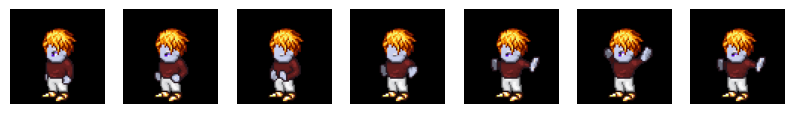

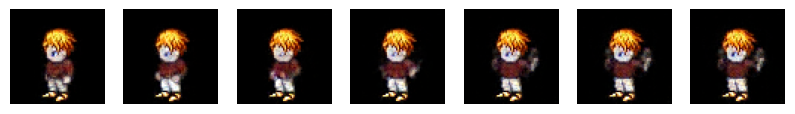

Reconstruction loss: 24.024812698364258


In [6]:
### TESTING RECONSTRUCTION ###
lldm = lldm.to('cuda')
lldm = lldm.eval()
#x = train_data[0].to('cuda').unsqueeze(0)


# z = lldm.encoder(x).embedding[0]
# _, z, _ = lldm.ddim_sampler.sample(shape = (1 , 3, 2, 2), x_last = z.reshape(1,3,2,2), cond = None)


# z = z.reshape(8,  12)
# x_rec = lldm.decoder(z).reconstruction

idx = torch.randint(0, len(train_dataset), (1,)).item()
x = train_dataset[idx]
z_seq, x_rec = lldm.reconstruct(x, vi_index = 3)

x = x.data.unsqueeze(0)
x = x.to(x_rec.device)
plot_sequence(x.data)
plot_sequence(x_rec)

recon_loss = (
                0.5 * (
                    F.mse_loss(
                        x_rec.reshape(x.shape[0]*lldm.n_obs, -1),
                        x.reshape(x.shape[0]*lldm.n_obs, -1),
                        reduction="none"
                    )).sum(dim=-1).reshape(x.shape[0], -1)
            ).mean(dim=-1).item()

print('Reconstruction loss:', recon_loss)


In [7]:
train_embeddings = [] 
log_vars = []

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
for i, x in enumerate(train_loader):
    x = x.to('cuda')
    out = lldm.encoder(x)
    z = out.embedding.reshape(-1, 7, 12)
    log_var = out.log_covariance
    train_embeddings.append(z.cpu().detach())
    log_vars.append(log_var.cpu().detach())
train_embeddings = torch.stack(train_embeddings).squeeze(1)
print(train_embeddings.shape)

torch.Size([8000, 7, 12])


Running Kmedoids
Finding temperature
Best temperature found:  42.63230514526367
Building metric
Increasing T by  1
Sampling 10 points on the 2th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...


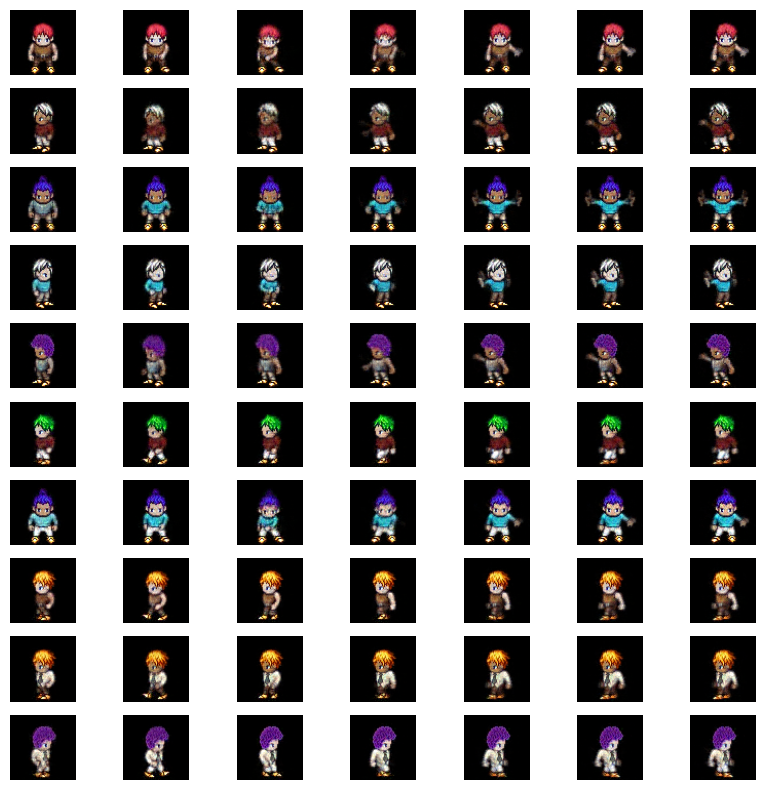

In [16]:
lldm.temperature = 1
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=10, vi_index =2 , T_multiplier = 1, freeze=False)
plot_sequence(recon_x)

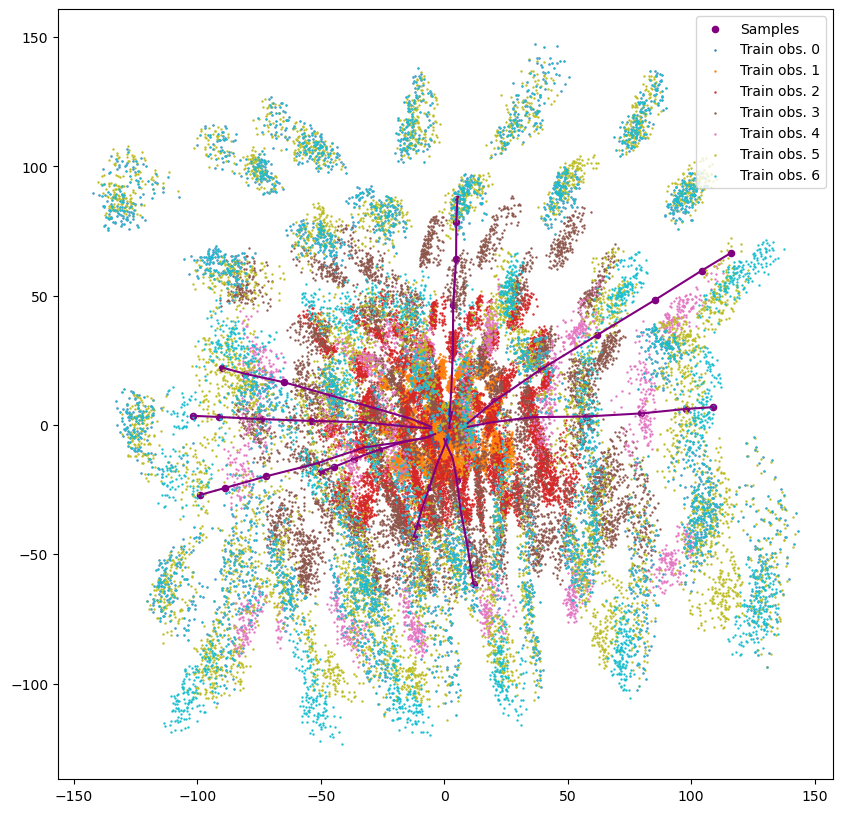

In [17]:
num_obs =  NUM_OBS =  train_data.shape[1] 
pca = PCA(n_components=2)
n_samples = z_seq.shape[0]
train_embeddings_pca = pca.fit_transform(train_embeddings.reshape(-1, latent_dim).cpu().detach().numpy()).reshape(-1, num_obs, 2)

displayed_indexes = range(num_obs)  #range(num_obs)

all_sequences = z_seq
all_sequences_pca = pca.transform(all_sequences.reshape(-1, latent_dim).cpu().detach().numpy())
all_sequences_pca = all_sequences_pca.reshape(n_samples, NUM_OBS, 2)
plt.figure(figsize=(10, 10))
plt.scatter(all_sequences_pca[:, :, 0], all_sequences_pca[:, :, 1], s=20, color='purple', label='Samples')
colors = plt.get_cmap('tab10', num_obs)
for i in displayed_indexes:
    plt.scatter(train_embeddings_pca[:, i, 0], train_embeddings_pca[:, i, 1], s=0.5, color=colors(i), label=f'Train obs. {i}')

for i in range(n_samples):
    plt.plot(all_sequences_pca[i, :, 0], all_sequences_pca[i, :, 1], c = 'purple')


plt.legend()
plt.show()


In [18]:
recon_x, z_seq = lldm.generate(train_data, num_gen_seq=test_data.shape[0], vi_index =2 , T_multiplier = 1)
print(recon_x.shape)
print(test_data.shape)

Running Kmedoids
Finding temperature
Best temperature found:  42.63230514526367
Building metric
Increasing T by  1
Sampling 2664 points on the 2th/rd manifold...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
Propagating in the past...
Propagating in the future...
Decoding...
torch.Size([2664, 7, 3, 64, 64])
torch.Size([2664, 7, 3, 64, 64])


In [19]:
import torch
from torcheval.metrics import FrechetInceptionDistance

def compute_fid_with_torcheval(real_images, generated_images, batch_size=256, device='cuda'):
    # Initialize FID metric
    fid_metric = FrechetInceptionDistance().to(device)
    
    def process_in_batches(images, real):
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            fid_metric.update(batch, is_real=real)
            # Clear the batch from memory
            del batch
            torch.cuda.empty_cache()
    
    # Process real images in batches
    process_in_batches(real_images, real=True)
    
    # Process generated images in batches
    process_in_batches(generated_images, real=False)
    
    # Compute the FID score
    fid_score = fid_metric.compute()
    return fid_score

# Example usage:
real_images = test_data.reshape(-1, 3, 64, 64).clamp(0, 1)
generated_images = recon_x.reshape(-1, 3, 64, 64).clamp(0, 1)

fid_score = compute_fid_with_torcheval(real_images, generated_images)
print('FID score:', fid_score)


FID score: tensor(36.7052, device='cuda:0')


In [24]:
test_nll = []
batch_size=100
n_runs=5
n_samples = batch_size
lldm.device = 'cuda'
for _ in range(n_runs):
    test_nll.append(lldm.get_nll(data=test_data, vi_index = 2, n_samples=n_samples, batch_size=batch_size))

test_nll

  0%|          | 3/2664 [00:00<04:39,  9.53it/s]

Current nll at 0: -11311.543867420238


  4%|▍         | 102/2664 [00:10<04:18,  9.90it/s]

Current nll at 100: -11315.136051774336


  8%|▊         | 202/2664 [00:20<04:11,  9.78it/s]

Current nll at 200: -11315.540293957481


 11%|█▏        | 302/2664 [00:30<03:59,  9.88it/s]

Current nll at 300: -11315.670319418166


 15%|█▌        | 402/2664 [00:40<03:47,  9.94it/s]

Current nll at 400: -11315.560335729982


 19%|█▉        | 503/2664 [00:50<03:36,  9.98it/s]

Current nll at 500: -11315.741437676617


 23%|██▎       | 603/2664 [01:00<03:27,  9.95it/s]

Current nll at 600: -11315.909856177997


 26%|██▋       | 702/2664 [01:10<03:18,  9.89it/s]

Current nll at 700: -11315.86153405802


 30%|███       | 802/2664 [01:21<03:20,  9.30it/s]

Current nll at 800: -11315.853927371105


 34%|███▍      | 903/2664 [01:31<02:56,  9.97it/s]

Current nll at 900: -11315.83067812924


 38%|███▊      | 1002/2664 [01:41<02:47,  9.94it/s]

Current nll at 1000: -11315.910959139053


 41%|████▏     | 1103/2664 [01:51<02:36,  9.99it/s]

Current nll at 1100: -11315.889548381234


 45%|████▌     | 1203/2664 [02:02<02:26,  9.97it/s]

Current nll at 1200: -11315.833687790864


 49%|████▉     | 1303/2664 [02:12<02:16, 10.00it/s]

Current nll at 1300: -11315.878060096373


 53%|█████▎    | 1402/2664 [02:22<02:06,  9.96it/s]

Current nll at 1400: -11315.840775533072


 56%|█████▋    | 1503/2664 [02:32<01:56, 10.00it/s]

Current nll at 1500: -11315.861374139384


 60%|██████    | 1602/2664 [02:42<01:46,  9.94it/s]

Current nll at 1600: -11315.816310429605


 64%|██████▍   | 1703/2664 [02:52<01:36,  9.97it/s]

Current nll at 1700: -11315.909827054795


 68%|██████▊   | 1802/2664 [03:02<01:26,  9.93it/s]

Current nll at 1800: -11315.876605561136


 71%|███████▏  | 1902/2664 [03:12<01:16,  9.93it/s]

Current nll at 1900: -11315.884811206151


 75%|███████▌  | 2003/2664 [03:22<01:06,  9.94it/s]

Current nll at 2000: -11315.904812240522


 79%|███████▉  | 2103/2664 [03:32<00:56,  9.97it/s]

Current nll at 2100: -11315.898968063639


 83%|████████▎ | 2203/2664 [03:42<00:46,  9.95it/s]

Current nll at 2200: -11315.8772621802


 86%|████████▋ | 2303/2664 [03:52<00:36,  9.95it/s]

Current nll at 2300: -11315.873115265227


 90%|█████████ | 2403/2664 [04:03<00:26,  9.98it/s]

Current nll at 2400: -11315.89127299797


 94%|█████████▍| 2502/2664 [04:12<00:16, 10.02it/s]

Current nll at 2500: -11315.934194007863


 98%|█████████▊| 2603/2664 [04:23<00:06,  9.95it/s]

Current nll at 2600: -11315.910376967653


  0%|          | 2/2664 [00:00<04:18, 10.29it/s]

Current nll at 0: -11311.549731001596


  4%|▍         | 103/2664 [00:10<04:16,  9.98it/s]

Current nll at 100: -11315.126088489107


  8%|▊         | 202/2664 [00:20<04:07,  9.94it/s]

Current nll at 200: -11315.54021706796


 11%|█▏        | 303/2664 [00:30<03:56,  9.96it/s]

Current nll at 300: -11315.67596174435


 15%|█▌        | 403/2664 [00:40<03:46,  9.97it/s]

Current nll at 400: -11315.563996690622


 19%|█▉        | 503/2664 [00:50<03:36,  9.96it/s]

Current nll at 500: -11315.74464371427


 23%|██▎       | 602/2664 [01:00<03:28,  9.91it/s]

Current nll at 600: -11315.91256325884


 26%|██▋       | 702/2664 [01:10<03:17,  9.92it/s]

Current nll at 700: -11315.863016380486


 30%|███       | 802/2664 [01:20<03:07,  9.93it/s]

Current nll at 800: -11315.856512950893


 34%|███▍      | 902/2664 [01:31<03:01,  9.70it/s]

Current nll at 900: -11315.832930455857


 38%|███▊      | 1002/2664 [01:41<02:47,  9.91it/s]

Current nll at 1000: -11315.911475554187


 41%|████▏     | 1103/2664 [01:51<02:37,  9.93it/s]

Current nll at 1100: -11315.888702104912


 45%|████▌     | 1203/2664 [02:01<02:26,  9.95it/s]

Current nll at 1200: -11315.833319022047


 49%|████▉     | 1303/2664 [02:11<02:16,  9.98it/s]

Current nll at 1300: -11315.877216607323


 53%|█████▎    | 1402/2664 [02:21<02:07,  9.93it/s]

Current nll at 1400: -11315.840165380252


 56%|█████▋    | 1503/2664 [02:31<01:56,  9.94it/s]

Current nll at 1500: -11315.860332182376


 60%|██████    | 1602/2664 [02:41<01:47,  9.92it/s]

Current nll at 1600: -11315.815808606163


 64%|██████▍   | 1703/2664 [02:51<01:36,  9.96it/s]

Current nll at 1700: -11315.908390784385


 68%|██████▊   | 1803/2664 [03:01<01:26,  9.90it/s]

Current nll at 1800: -11315.87466226744


 71%|███████▏  | 1903/2664 [03:11<01:16,  9.98it/s]

Current nll at 1900: -11315.883603312745


 75%|███████▌  | 2003/2664 [03:21<01:06,  9.99it/s]

Current nll at 2000: -11315.90269076559


 79%|███████▉  | 2103/2664 [03:31<00:56,  9.99it/s]

Current nll at 2100: -11315.898068149037


 83%|████████▎ | 2203/2664 [03:41<00:46,  9.95it/s]

Current nll at 2200: -11315.876430130542


 86%|████████▋ | 2302/2664 [03:51<00:36,  9.94it/s]

Current nll at 2300: -11315.872354204876


 90%|█████████ | 2403/2664 [04:02<00:26,  9.96it/s]

Current nll at 2400: -11315.890321128561


 94%|█████████▍| 2503/2664 [04:12<00:16, 10.00it/s]

Current nll at 2500: -11315.933016015118


 98%|█████████▊| 2603/2664 [04:22<00:06,  9.99it/s]

Current nll at 2600: -11315.909316620127


  0%|          | 2/2664 [00:00<04:18, 10.30it/s]

Current nll at 0: -11311.46535984566


  4%|▍         | 102/2664 [00:10<04:15, 10.01it/s]

Current nll at 100: -11315.14771672397


  8%|▊         | 203/2664 [00:20<04:07,  9.95it/s]

Current nll at 200: -11315.559227070067


 11%|█▏        | 302/2664 [00:30<03:58,  9.90it/s]

Current nll at 300: -11315.684359933863


 15%|█▌        | 402/2664 [00:40<03:48,  9.91it/s]

Current nll at 400: -11315.571927576913


 19%|█▉        | 502/2664 [00:50<03:38,  9.90it/s]

Current nll at 500: -11315.748167908243


 23%|██▎       | 602/2664 [01:00<03:28,  9.91it/s]

Current nll at 600: -11315.915006515119


 26%|██▋       | 702/2664 [01:10<03:17,  9.93it/s]

Current nll at 700: -11315.866356601511


 30%|███       | 803/2664 [01:20<03:06,  9.96it/s]

Current nll at 800: -11315.857766350038


 34%|███▍      | 903/2664 [01:30<02:57,  9.92it/s]

Current nll at 900: -11315.833994901092


 38%|███▊      | 1003/2664 [01:40<02:46,  9.97it/s]

Current nll at 1000: -11315.912965840049


 41%|████▏     | 1103/2664 [01:51<02:36, 10.00it/s]

Current nll at 1100: -11315.891634170668


 45%|████▌     | 1203/2664 [02:01<02:26,  9.98it/s]

Current nll at 1200: -11315.834390279304


 49%|████▉     | 1303/2664 [02:11<02:16,  9.97it/s]

Current nll at 1300: -11315.879275792386


 53%|█████▎    | 1402/2664 [02:21<02:07,  9.92it/s]

Current nll at 1400: -11315.842573073154


 56%|█████▋    | 1502/2664 [02:31<01:57,  9.93it/s]

Current nll at 1500: -11315.862336630658


 60%|██████    | 1603/2664 [02:41<01:46,  9.99it/s]

Current nll at 1600: -11315.81745309263


 64%|██████▍   | 1702/2664 [02:51<01:36,  9.94it/s]

Current nll at 1700: -11315.909958097587


 68%|██████▊   | 1803/2664 [03:01<01:26,  9.98it/s]

Current nll at 1800: -11315.876494972143


 71%|███████▏  | 1903/2664 [03:11<01:16,  9.96it/s]

Current nll at 1900: -11315.885563340487


 75%|███████▌  | 2002/2664 [03:21<01:06,  9.95it/s]

Current nll at 2000: -11315.905000772009


 79%|███████▉  | 2102/2664 [03:31<00:56,  9.92it/s]

Current nll at 2100: -11315.89919774937


 83%|████████▎ | 2202/2664 [03:41<00:46, 10.01it/s]

Current nll at 2200: -11315.877588263511


 86%|████████▋ | 2303/2664 [03:51<00:36, 10.03it/s]

Current nll at 2300: -11315.873067147213


 90%|█████████ | 2403/2664 [04:01<00:26, 10.03it/s]

Current nll at 2400: -11315.890984633159


 94%|█████████▍| 2503/2664 [04:11<00:16, 10.00it/s]

Current nll at 2500: -11315.933138176522


 98%|█████████▊| 2603/2664 [04:21<00:06, 10.02it/s]

Current nll at 2600: -11315.910056690762


  0%|          | 2/2664 [00:00<04:19, 10.26it/s]

Current nll at 0: -11311.520954998592


  4%|▍         | 103/2664 [00:10<04:16,  9.98it/s]

Current nll at 100: -11315.121097894995


  8%|▊         | 202/2664 [00:20<04:07,  9.93it/s]

Current nll at 200: -11315.545427766994


 11%|█▏        | 302/2664 [00:30<03:58,  9.92it/s]

Current nll at 300: -11315.680223289128


 15%|█▌        | 403/2664 [00:40<03:48,  9.90it/s]

Current nll at 400: -11315.564571309602


 19%|█▉        | 502/2664 [00:50<03:38,  9.90it/s]

Current nll at 500: -11315.742568673446


 23%|██▎       | 602/2664 [01:00<03:28,  9.88it/s]

Current nll at 600: -11315.912918139577


 26%|██▋       | 702/2664 [01:10<03:18,  9.90it/s]

Current nll at 700: -11315.865638525933


 30%|███       | 803/2664 [01:21<03:07,  9.93it/s]

Current nll at 800: -11315.85915739497


 34%|███▍      | 903/2664 [01:31<02:56,  9.95it/s]

Current nll at 900: -11315.835948167949


 38%|███▊      | 1002/2664 [01:41<02:47,  9.93it/s]

Current nll at 1000: -11315.914621693819


 41%|████▏     | 1103/2664 [01:51<02:37,  9.93it/s]

Current nll at 1100: -11315.892859183225


 45%|████▌     | 1202/2664 [02:01<02:27,  9.92it/s]

Current nll at 1200: -11315.83520213866


 49%|████▉     | 1302/2664 [02:11<02:21,  9.62it/s]

Current nll at 1300: -11315.877998125454


 53%|█████▎    | 1402/2664 [02:22<02:13,  9.48it/s]

Current nll at 1400: -11315.840177332197


 56%|█████▋    | 1502/2664 [02:32<02:02,  9.48it/s]

Current nll at 1500: -11315.86099011018


 60%|██████    | 1602/2664 [02:43<01:51,  9.49it/s]

Current nll at 1600: -11315.816118105855


 64%|██████▍   | 1702/2664 [02:53<01:41,  9.49it/s]

Current nll at 1700: -11315.90836873164


 68%|██████▊   | 1802/2664 [03:04<01:30,  9.49it/s]

Current nll at 1800: -11315.875421395343


 71%|███████▏  | 1902/2664 [03:14<01:20,  9.48it/s]

Current nll at 1900: -11315.884399987463


 75%|███████▌  | 2002/2664 [03:25<01:09,  9.48it/s]

Current nll at 2000: -11315.904858184631


 79%|███████▉  | 2102/2664 [03:36<00:59,  9.49it/s]

Current nll at 2100: -11315.899179364666


 83%|████████▎ | 2202/2664 [03:46<00:48,  9.50it/s]

Current nll at 2200: -11315.877568125403


 86%|████████▋ | 2302/2664 [03:57<00:38,  9.52it/s]

Current nll at 2300: -11315.873502427094


 90%|█████████ | 2402/2664 [04:07<00:27,  9.50it/s]

Current nll at 2400: -11315.891361249196


 94%|█████████▍| 2502/2664 [04:18<00:17,  9.52it/s]

Current nll at 2500: -11315.934441432155


 98%|█████████▊| 2602/2664 [04:28<00:06,  9.51it/s]

Current nll at 2600: -11315.910845297343


  0%|          | 2/2664 [00:00<04:33,  9.74it/s]

Current nll at 0: -11311.482594495856


  4%|▍         | 102/2664 [00:10<04:29,  9.50it/s]

Current nll at 100: -11315.13029851385


  8%|▊         | 202/2664 [00:21<04:19,  9.47it/s]

Current nll at 200: -11315.542657374428


 11%|█▏        | 302/2664 [00:31<04:09,  9.46it/s]

Current nll at 300: -11315.675164346778


 15%|█▌        | 402/2664 [00:42<03:58,  9.48it/s]

Current nll at 400: -11315.563658001514


 19%|█▉        | 502/2664 [00:52<03:48,  9.46it/s]

Current nll at 500: -11315.74339369937


 23%|██▎       | 602/2664 [01:03<03:37,  9.48it/s]

Current nll at 600: -11315.912027781951


 26%|██▋       | 702/2664 [01:14<03:26,  9.48it/s]

Current nll at 700: -11315.864637528352


 30%|███       | 802/2664 [01:24<03:16,  9.49it/s]

Current nll at 800: -11315.856638004336


 34%|███▍      | 902/2664 [01:35<03:00,  9.74it/s]

Current nll at 900: -11315.834072224843


 38%|███▊      | 1002/2664 [01:45<02:49,  9.79it/s]

Current nll at 1000: -11315.913664950465


 41%|████▏     | 1102/2664 [01:55<02:39,  9.77it/s]

Current nll at 1100: -11315.891222707998


 45%|████▌     | 1202/2664 [02:06<02:29,  9.81it/s]

Current nll at 1200: -11315.833367168498


 49%|████▉     | 1302/2664 [02:16<02:19,  9.76it/s]

Current nll at 1300: -11315.877322533866


 53%|█████▎    | 1402/2664 [02:26<02:08,  9.79it/s]

Current nll at 1400: -11315.83953512023


 56%|█████▋    | 1502/2664 [02:36<01:58,  9.80it/s]

Current nll at 1500: -11315.860471649594


 60%|██████    | 1602/2664 [02:47<01:48,  9.78it/s]

Current nll at 1600: -11315.816173697838


 64%|██████▍   | 1702/2664 [02:57<01:38,  9.77it/s]

Current nll at 1700: -11315.90880957975


 68%|██████▊   | 1802/2664 [03:07<01:28,  9.77it/s]

Current nll at 1800: -11315.876133899605


 71%|███████▏  | 1902/2664 [03:17<01:17,  9.79it/s]

Current nll at 1900: -11315.88469233719


 75%|███████▌  | 2002/2664 [03:28<01:07,  9.78it/s]

Current nll at 2000: -11315.904337322883


 79%|███████▉  | 2102/2664 [03:38<00:57,  9.79it/s]

Current nll at 2100: -11315.899211519993


 83%|████████▎ | 2202/2664 [03:48<00:47,  9.80it/s]

Current nll at 2200: -11315.877174368952


 86%|████████▋ | 2302/2664 [03:58<00:38,  9.41it/s]

Current nll at 2300: -11315.872836696028


 90%|█████████ | 2402/2664 [04:08<00:26,  9.80it/s]

Current nll at 2400: -11315.890326630935


 94%|█████████▍| 2502/2664 [04:19<00:16,  9.77it/s]

Current nll at 2500: -11315.93323361251


 98%|█████████▊| 2602/2664 [04:29<00:06,  9.79it/s]

Current nll at 2600: -11315.90952584551


100%|██████████| 2664/2664 [04:35<00:00,  9.67it/s]


[-11315.910957349177,
 -11315.909457325748,
 -11315.910423372174,
 -11315.91160959833,
 -11315.91045229664]